In [34]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from MHrank import MH_sample 
from eprank import exprop
import pandas
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [35]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
games = data['G'] - 1
num_players = W.shape[0]
num_games = games.shape[0]

# MCMC sampling (this may take a minute)

In [36]:
# number of iterations -- the more the better!
num_its = 10000
# perform Metropolis MCMC sampling, skill samples is an num_players x num_samples array
skill_samples = MH_sample(games, num_players, num_its)

# discard the first half of the samples (burn-in period)
# skill_samples = skill_samples[:,num_its//2:]

100%|██████████| 10000/10000 [01:34<00:00, 105.84it/s]

Acceptance rate: 0.448


['Novak-Djokovic']


[]

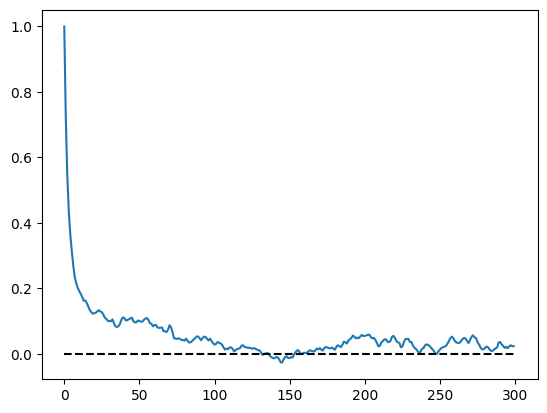

In [48]:
# plotting the autocorrelation function for player i
i = 15
l = 300
autocor = np.zeros(l)
print(W[i])
for t in range(l):
    autocor[t]=pandas.Series.autocorr(pandas.Series(skill_samples[i,:]),lag=t)
plt.plot(autocor)
plt.plot([0,l],[0,0],'k--')
plt.plot()

Text(0.5, 1.0, "Skill samples for player ['Novak-Djokovic']")

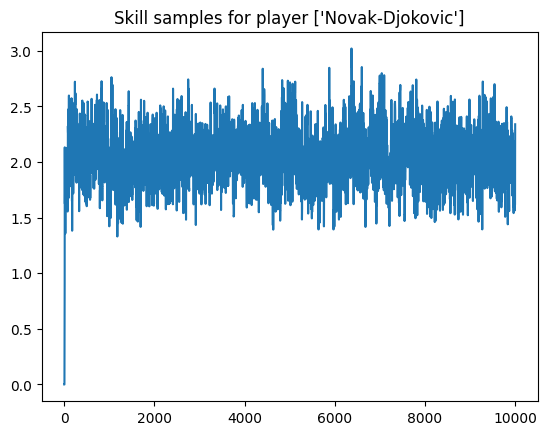

In [38]:
i = 15
plt.plot(range(num_its), skill_samples[i, :])
plt.title(f'Skill samples for player {W[i]}')

# Expectation propagation ranking

In [49]:
# run message passing algorithm, returns mean and variance for each player
ep_mean, ep_var = exprop(games, num_players, num_its = 3).T

# ArviZ Statistics Check

In [40]:
import arviz as az 
chain = skill_samples[:, :, np.newaxis].T
print(chain.shape)
idata = az.from_dict(posterior={"x": chain})
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


(1, 10000, 107)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],1.604,0.211,1.214,1.994,0.011,0.004,384.0,785.0,NaN
x[1],0.302,0.219,-0.133,0.693,0.011,0.004,405.0,1163.0,NaN
x[2],0.839,0.213,0.443,1.236,0.011,0.004,412.0,1293.0,NaN
x[3],0.620,0.204,0.235,1.002,0.011,0.004,364.0,981.0,NaN
x[4],1.652,0.226,1.238,2.070,0.012,0.004,378.0,1447.0,NaN
...,...,...,...,...,...,...,...,...,...
x[102],-0.828,0.815,-2.344,0.663,0.029,0.016,767.0,1247.0,NaN
x[103],-0.595,0.863,-2.252,1.038,0.032,0.019,749.0,1113.0,NaN
x[104],-1.295,0.537,-2.329,-0.320,0.015,0.009,1294.0,1882.0,NaN
x[105],-0.398,0.819,-1.987,1.069,0.028,0.016,860.0,1414.0,NaN


# Top 4 

In [77]:
i = 15
burn_in = 300

top4_ind = np.argsort(-ep_mean)[:4]
for i in top4_ind:
    print(f'Player: {W[i]}')
    print(f'MCMC mean skill: {np.mean(skill_samples[i,burn_in:])}')
    print(f'EP mean skill: {ep_mean[i]}')
    print(f'MCMC skill std: {np.std(skill_samples[i,burn_in:])}')
    print(f'EP skill std: {np.sqrt(ep_var[i])}')
    print('---')

Player: ['Novak-Djokovic']
MCMC mean skill: 2.0488402885762893
EP mean skill: 2.0301310217576893
MCMC skill std: 0.23794633085048258
EP skill std: 0.21753276779234082
---
Player: ['Roger-Federer']
MCMC mean skill: 1.6532334584712822
EP mean skill: 1.6334559163744096
MCMC skill std: 0.2239817831880667
EP skill std: 0.20714506709595834
---
Player: ['Rafael-Nadal']
MCMC mean skill: 1.6037808475647286
EP mean skill: 1.5633363540783958
MCMC skill std: 0.2092135920869345
EP skill std: 0.20426094105399673
---
Player: ['Andy-Murray']
MCMC mean skill: 1.4029349211219493
EP mean skill: 1.3722077089610594
MCMC skill std: 0.22279567466952838
EP skill std: 0.1879144465728016
---


In [ ]:
from scipy.stats import norm
top4_ind = np.argsort(-ep_mean)[:4]
top4_players = W[top4_ind][:,0].tolist()
top4_skill_mcmc = np.mean(skill_samples[top4_ind,burn_in:], axis=1)
top4_skill_ep = ep_mean[top4_ind]

gap = 9

print("Top 4 players win rate according to MCMC:")
str_0 = "   ".join(top4_players[i] for i in range(4))
print(" " * 15 + str_0)
for i in range(4):
    print(top4_players[i], end=" " * gap)
    for j in range(4):
        if i != j:
            win_prob_mcmc = norm.cdf(top4_skill_mcmc[i] - top4_skill_mcmc[j])
            print(f"{win_prob_mcmc:.3f}" + " " * gap, end='')
        else:
            print(" - " + " " * gap, end='')
    print('\n')

print("\n")

print("Top 4 players win rate according to EP:")
str_0 = "   ".join(top4_players[i] for i in range(4))
print(" " * 15 + str_0)
for i in range(4):
    print(top4_players[i], end=" " * gap)
    for j in range(4):
        if i != j:
            win_prob_mcmc = norm.cdf(top4_skill_ep[i] - top4_skill_ep[j])
            print(f"{win_prob_mcmc:.3f}" + " " * gap, end='')
        else:
            print(" - " + " " * gap, end='')
    print('\n')


Top 4 players win rate according to MCMC:
               Novak-Djokovic   Roger-Federer   Rafael-Nadal   Andy-Murray
Novak-Djokovic          -          0.654         0.672         0.741         

Roger-Federer         0.346          -          0.520         0.599         

Rafael-Nadal         0.328         0.480          -          0.580         

Andy-Murray         0.259         0.401         0.420          -          



Top 4 players win rate according to EP:
               Novak-Djokovic   Roger-Federer   Rafael-Nadal   Andy-Murray
Novak-Djokovic          -          0.654         0.680         0.745         

Roger-Federer         0.346          -          0.528         0.603         

Rafael-Nadal         0.320         0.472          -          0.576         

Andy-Murray         0.255         0.397         0.424          -          

Top 4 players skill diff probability according to EP:
               Novak-Djokovic   Roger-Federer   Rafael-Nadal   Andy-Murray
Novak-Djokovic   

In [81]:
print("Top 4 players skill diff probability according to EP:")
str_0 = "   ".join(top4_players[i] for i in range(4))
print(" " * 15 + str_0)
for i in range(4):
    print(top4_players[i], end=" " * gap)
    for j in range(4):
        if i != j:
            win_prob_mcmc = norm.cdf((top4_skill_ep[i] - top4_skill_ep[j]) / np.sqrt(ep_var[i] + ep_var[j]))
            print(f"{win_prob_mcmc:.3f}" + " " * gap, end='')
        else:
            print(" - " + " " * gap, end='')
    print('\n')

Top 4 players skill diff probability according to EP:
               Novak-Djokovic   Roger-Federer   Rafael-Nadal   Andy-Murray
Novak-Djokovic          -          0.921         0.947         0.995         

Roger-Federer         0.079          -          0.599         0.856         

Rafael-Nadal         0.053         0.401          -          0.773         

Andy-Murray         0.005         0.144         0.227          -          



# Nadal and Federer

Marginal distribution of skill of Nadal and Federer


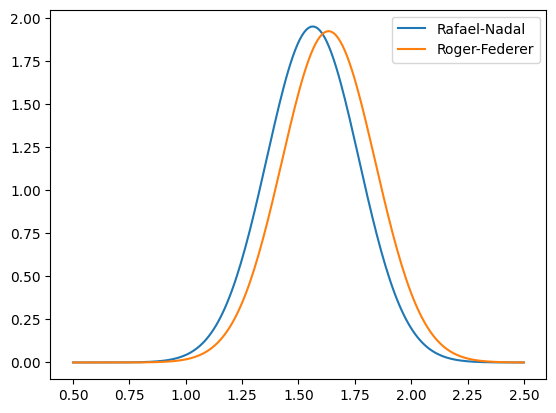

In [86]:
federer_idx = top4_ind[1]
nadal_idx = top4_ind[2]
print("Marginal distribution of skill of Nadal and Federer")
x = np.linspace(0.5, 2.5, 200)
b_nadal = norm.pdf(x, loc=ep_mean[nadal_idx], scale=np.sqrt(ep_var[nadal_idx]))
b_federer = norm.pdf(x, loc=ep_mean[federer_idx], scale=np.sqrt(ep_var[federer_idx]))
plt.plot(x, b_nadal)
plt.plot(x, b_federer)
plt.legend([W[nadal_idx][0], W[federer_idx][0]])